In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.integrate as integ
from scipy.spatial import Delaunay
import matplotlib.tri as mtri

from plot_triangulation import plot_triangle, plot_mesh

# Elementos finitos 2D

Vamos a extender lo visto sobre la técnica de elementos finitos de una a dos dimensiones.
Comenzaremos por __triangular__ (es decir, descomponer en triángulos) el dominio y usaremos como elementos funciones continuas que son lineales a trozos en cada triángulo.

Las `2` coordenadas de los `N` nodos se almacenan de una manera obvia: en una array `Nx2`.

La información de los triángulos se almacena de una forma muy diferente.

_Los vértices no determinan los triángulos_, pero no necesitamos almacenar en un array las coordenadas de los vértices de cada triángulo. Es suficiente con almacenar en un array `Tx3` los índices que ocupan los `3` vértices en el array de vértices.

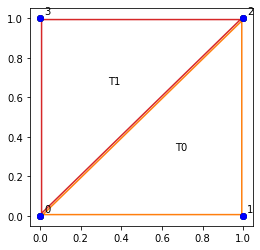

In [2]:
vertices = np.array([
    [0,0],
    [1,0],
    [1,1],
    [0,1]
])
ivertices_boundary = np.arange(4)

triangles = np.array([
    [0,1,2],
    [0,2,3],
])

plt.figure(figsize=(4,4))
plot_mesh(vertices, ivertices_boundary, triangles)

Otra triangulación distinta con los mismos nodos.

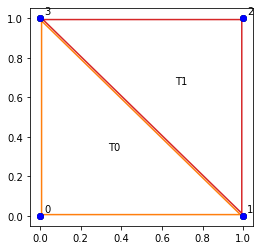

In [3]:
vertices = np.array([
    [0,0],
    [1,0],
    [1,1],
    [0,1]
])
ivertices_boundary = np.arange(4)

triangles = np.array([
    [0,1,3],
    [1,2,3],
])

plt.figure(figsize=(4,4))
plot_mesh(vertices, ivertices_boundary, triangles)

In [4]:
def square_mesh(n, L=1):
    nboundary_vertices = 4*n
    ninterior_vertices = (n-1)*(n-1)
    
    nvertices = (n+1)*(n+1)
    vertices = np.zeros((nvertices, 2))
    xx, yy = np.meshgrid(np.linspace(0,L,n+1), np.linspace(0,L,n+1))
    vertices[:,0] = xx.reshape(nvertices)
    vertices[:,1] = yy.reshape(nvertices)
    
    ivertices_boundary = (
        (vertices[:,0]==0) | #south
        (vertices[:,1]==1) | #east
        (vertices[:,0]==1) | #north
        (vertices[:,1]==0)   #west
    )
    ivertices_boundary = [
        iv for iv in range(nvertices) if
        ((vertices[iv][0]==0) | #south
         (vertices[iv][1]==1) | #east
         (vertices[iv][0]==1) | #north
         (vertices[iv][1]==0)   #west
        )
    ]
    triangles = np.zeros((2*n*n,3), dtype=np.int32)
    itriangle_counter = 0
    for i in range(n):
        for j in range(n):
            triangles[itriangle_counter,:] = [i*(n+1)+j, i*(n+1)+j+1, (i+1)*(n+1)+j]
            triangles[itriangle_counter+1,:] = [i*(n+1)+j+1, (i+1)*(n+1)+j+1, (i+1)*(n+1)+j]
            itriangle_counter += 2

    return vertices, ivertices_boundary, triangles

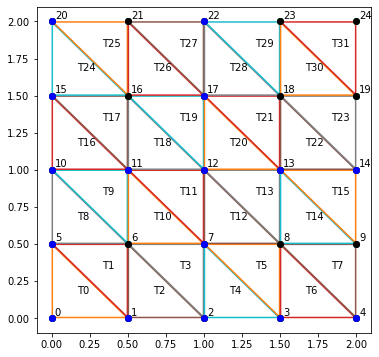

In [5]:
vertices, ivertices_boundary, triangles = square_mesh(4, L=2)
plt.figure(figsize=(6,6))
plot_mesh(vertices,ivertices_boundary,triangles)

Lo más interesante de esta técnica es que se pueden triangular dominios muy variados...

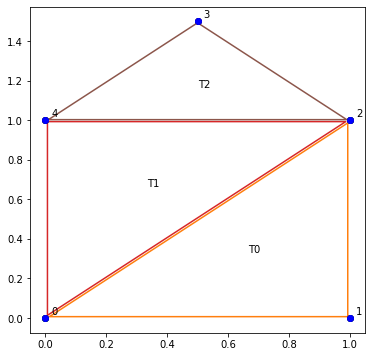

In [6]:
vertices = np.array([
    [0,0],
    [1,0],
    [1,1],
    [1/2,3/2],
    [0,1]
])
ivertices_boundary = np.arange(5)

triangles = np.array([
    [0,1,2],
    [0,2,4],
    [2,3,4]
])

plt.figure(figsize=(6,6))
plot_mesh(vertices, ivertices_boundary, triangles)

Una técnica útil es buscar vértices que estén repartidos de la forma que nos interese, y luego buscar una __triangulación de Delaunay__, en la que se controla el __aspect ratio__ de los triángulos: el objetivo es que el mayor __diámetro de un triángulo__ de la triangulación sea lo más pequeño posible. Es algo importante para mantener la estabilidad y tener buenas cotas de error. _Si tenemos un triángulo con poca área pero muy alargado la cota de error es grande_.

[[4 2 3]
 [2 4 1]
 [1 4 0]]


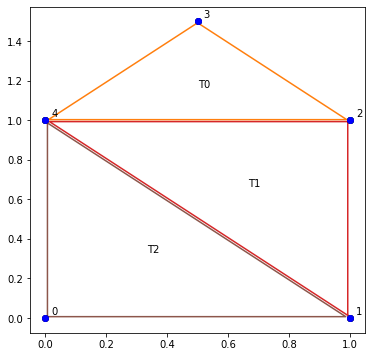

In [7]:
tri = Delaunay(vertices)
print(tri.simplices)
plt.figure(figsize=(6,6))
plot_mesh(vertices, ivertices_boundary, tri.simplices)

Comprobamos en la malla regular que la triangulación de Delaunay no es única (aunque casi siempre lo es).

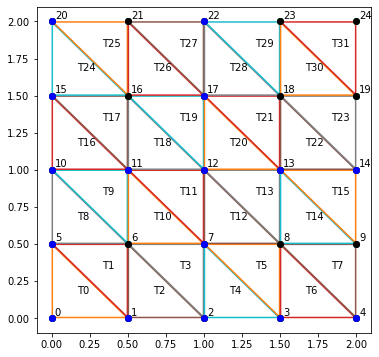

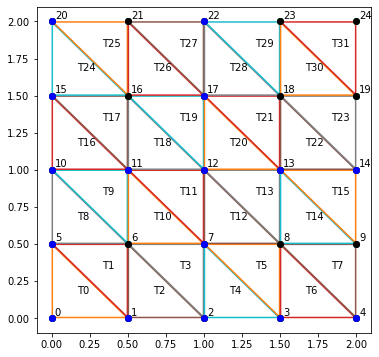

In [8]:
vertices_sq, ivertices_boundary_sq, triangles_sq = square_mesh(4, L=2)
plt.figure(figsize=(6,6))
plot_mesh(vertices_sq, ivertices_boundary_sq, triangles_sq)

triangles_Delaunay = Delaunay(vertices).simplices
plt.figure(figsize=(6,6))
plot_mesh(vertices_sq, ivertices_boundary_sq, triangles_sq)

Usamos la triangulación de Delaunay para refinar una triangulación existente, añadiendo el punto medio de cada segmento de la frontera, y el baricentro de cada triángulo (se puede hacer mejor, pero sirva para ilustrar).

In [9]:
def refine_mesh(vertices, ivertices_boundary, triangles):
    nvertices, _ = vertices.shape
    nvertices_boundary = len(ivertices_boundary)
    nvertices_interior = nvertices - nvertices_boundary
    vertices_boundary = vertices[ivertices_boundary]
    vertices_interior = vertices[[j for j in range(nvertices)
                                  if j not in ivertices_boundary]]
    ntriangles, _ = triangles.shape
    new_nvertices_boundary = 2*nvertices_boundary
    new_ivertices_boundary = np.arange(new_nvertices_boundary)
    new_nvertices_interior = nvertices_interior + ntriangles
    
    new_vertices = np.zeros((new_nvertices_boundary + new_nvertices_interior, 2))
    new_vertices[:new_nvertices_boundary:2, :] = vertices_boundary
    for j in range(nvertices_boundary):
        iv  = ivertices_boundary[j]
        iv1 = ivertices_boundary[(j+1)%nvertices_boundary]
        new_vertices[2*j+1, :] = 0.5*(vertices[iv]+vertices[iv1])
    new_vertices[new_nvertices_boundary:new_nvertices_boundary+nvertices_interior, :] = vertices_interior
    for j in range(len(triangles)):
        triangle = triangles[j]
        v1,v2,v3 = triangle
        vbarycenter = new_nvertices_boundary+nvertices_interior+j
        barycenter = vertices[triangle].mean(axis=0)
        new_vertices[vbarycenter, :] = barycenter
    
    tri = Delaunay(new_vertices)
    new_triangles = tri.simplices
    return new_vertices, new_ivertices_boundary, new_triangles
    

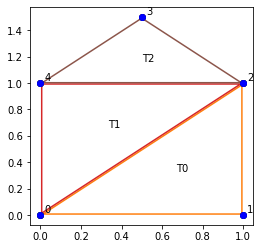

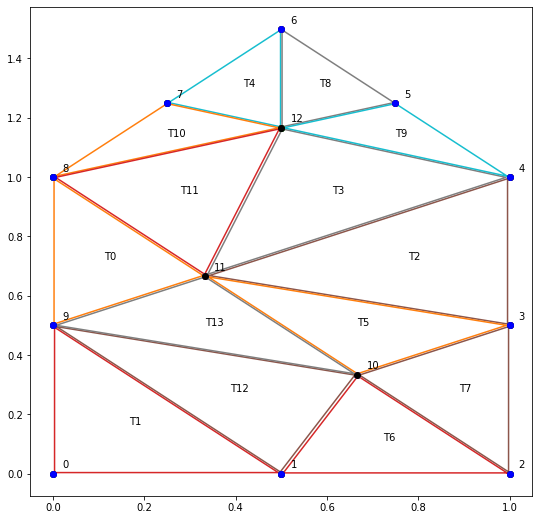

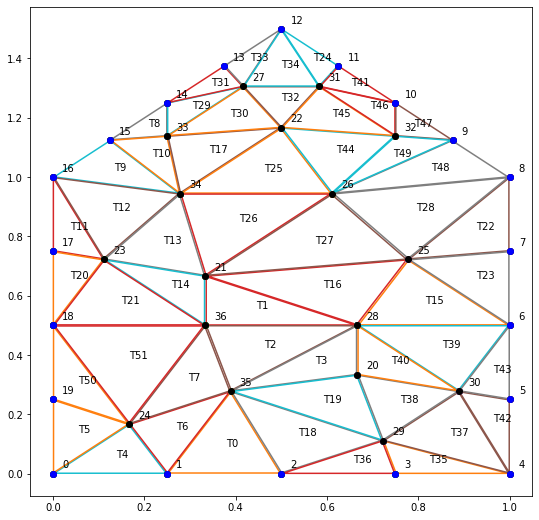

In [10]:
plt.figure(figsize=(4,4))
plot_mesh(vertices, ivertices_boundary, triangles)

plt.figure(figsize=(9,9))
vertices2, ivertices_boundary2, triangles2 = refine_mesh(vertices, ivertices_boundary, triangles)
plot_mesh(vertices2,ivertices_boundary2,triangles2)

plt.figure(figsize=(9,9))
vertices3, ivertices_boundary3, triangles3 = refine_mesh(vertices2, ivertices_boundary2, triangles2)
plot_mesh(vertices3,ivertices_boundary3,triangles3)

vertices4, ivertices_boundary4, triangles4 = refine_mesh(vertices3, ivertices_boundary3, triangles3)
vertices5, ivertices_boundary5, triangles5 = refine_mesh(vertices4, ivertices_boundary4, triangles4)
vertices6, ivertices_boundary6, triangles6 = refine_mesh(vertices4, ivertices_boundary4, triangles4)


Queremos resolver una ecuación del tipo:
$$
-\Delta u = f 
$$
o, escribiendo las variables $x$ e $y$
$$
-\Delta u(x,y) = f (x,y)
$$
en el dominio $\Omega$, con condiciones de frontera $u(x,y)=0$ para $(x,y)\in\partial\Omega$.

Fijamos una serie de nodos $p_0,p_1,\dots,p_{n}\in \Omega$, y una triangulación que tiene a estos nodos como vértices de los triángulos.
Buscamos una solución aproximada en el espacio $V$ de funciones continuas que además son lineales en cada triángulo y que valen 0 en toda la frontera.

En este espacio, la ecuación anterior es cierta si y sólo si el producto de $-\Delta u(x,y) = f(x,y)$ por cualquier función $v\in V$ tiene integral 0:
$$
\int_\Omega \left(-\Delta u(x,y) - f(x,y) \right) v(x,y) = 0\;\text{ para cualquier }v\in V
$$


Esa integral se puede simplificar un poco integrando por partes (usando que $v(x)=0$ en $\partial\Omega$).
$$
\int_\Omega \nabla u(x,y)\cdot \nabla v(x,y) - f(x,y) v(x,y) = 0\;\text{ para cualquier }v\in V
$$
y vemos que esta integral es exactamente la derivada del funcional $E$ en el "punto" $u$ y en la dirección $v$, donde $E$ es un _funcional de energía_ definido en el espacio $V$ (a cada función de $V$ le asigna un número real):
$$
E(u)=\frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dxdy - \int_\Omega f(x,y) u(x,y) dxdy
$$

> _Cualquier solución de la ecuación diferencial es un punto crítico del funcional de energía, y viceversa._

$$
-\Delta u = f\; \text{ en sentido "débil", en }V\Leftrightarrow \nabla_u E(v)=0 \text{ para cualquier }v\in V\Leftrightarrow \nabla_u E=0
$$

De hecho, el funcional $E$ es cuadrático y convexo, y tiene un único punto crítico, que es un mínimo.

Cualquier función de $V$ se puede escribir en la forma
$$
u(x,y) = \sum_{i=1}^n c_i\phi_i(x,y)
$$
Donde $\phi_i$ son funciones que forman una base de $V$. 
La función $\phi_i$ es la única función de $V$ que vale $1$ en $p_i$, y $0$ en todos los demás nodos. En cada triángulo es lineal y por lo tanto su gradiente es constante.

Si desarrollamos el funcional de energía en esta base tenemos:
$$
\begin{array}{rcll}
E(u)&=&\frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dxdy - \int_\Omega f(x,y) u(x,y) dxdy
\end{array}
$$
$$
\begin{array}{rcl}
E\left(\sum_{i=1}^n c_i\phi_i(x,y)\right)&=& \left(\sum_{i=1}^n \sum_{j=1}^n c_jc_i\int_\Omega\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)\right) \\
                        &&- \sum_{i=1}^n c_i\int_\Omega f(x,y)\phi_i(x,y)  = 0
\end{array}
$$

Definimos:
 - Una matriz $A$ cuya entrada $i,j$ es $\int_\Omega\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$.
 - Un vector $\mathbf{b}$ cuya entrada $i$ es $\int_\Omega f(x,y)\phi_i(x,y)\:dx$.
 - Un vector $\mathbf{c}$ cuya entrada $i$ es la incógnita $c_i$.
 
El funcional $E$ toma la forma:
$$
\begin{array}{rcll}
E(u)=E\left(\sum_{i=1}^n c_i\phi_i(x,y)\right)=E(\mathbf{c})&=&\mathbf{c}^T\cdot A\cdot \mathbf{c} - \mathbf{c}^T\cdot\mathbf{b}\\
\end{array}
$$

 Si $x_i$ no es adyacente a $x_j$ en la triangulación, la integral $\int_\Omega\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$ es $0$. Si son adyacentes, o iguales, la integral es una suma de integrales sobre triángulos de funciones constantes.

Es decir, __la matriz $A$ tiene muchos ceros__.

El funcional $E$ es cuadrático y definido positivo, y por tanto tiene un mínimo absoluto en su único punto crítico, que se obtiene derivando e igualando a cero:
$$
\nabla_{\mathbf{c}} E = A\cdot \mathbf{c} - \mathbf{b} = \mathbf{0}
$$
y finalmente encontramos una solución de nuestro problema variacional resolviendo un sistema de ecuaciones lineales.

En vez de rellenar `A` y `b` rellenando el término de la fila `i`, columna `j`, es más fácil recorrer los triángulos, incorporando la contribución de cada triángulo a la matriz `A` y al vector `b`.

Por ejemplo, sobre el triángulo $T$ con vértices $p_i,p_j,p_k$ queremos hacer tres integrales:
$$
\int_T f(x,y)\phi_i(x,y)\:dx\:dy,\;
\int_T f(x,y)\phi_j(x,y)\:dx\:dy,\;
\int_T f(x,y)\phi_k(x,y)\:dx\:dy
$$
que debemos sumar a los términos $b_i,b_j,b_k$, respectivamente, como contribuciones distintas a las integrales que las definen:
$$
b_i=\int_\Omega f(x,y)\phi_i(x,y)\:dx\:dy,\;
b_j=\int_\Omega f(x,y)\phi_j(x,y)\:dx\:dy,\;
b_k=\int_\Omega f(x,y)\phi_k(x,y)\:dx\:dy
$$


Observamos la función lineal $\phi_i$, que vale $1$ en el nodo $p_i$ y 0 en el resto de nodos, restringida al triángulo $T$, con vértices $p_i,p_j,p_k$.

La función verifica este sistema de ecuaciones
$$
\begin{array}{lcr}
  \phi_i(p_i)&=&1\\
  \phi_i(p_j)&=&0\\
  \phi_i(p_k)&=&0
\end{array}
$$
Si desarrollamos $\phi_i(x,y) = a_i x+b_i y+c_i$, las incógnitas son $a,b,c$. Sabemos que satisfacen las ecuaciones:
$$
\begin{array}{lcr}
  a_i x_i+b_i y_i+c_i&=&1\\
  a_i x_j+b_i y_j+c_i&=&0\\
  a_i x_k+b_i y_k+c_i&=&0
\end{array}
$$

En resumen, un sistema lineal de ecuaciones para los coeficientes de $\phi_i$ con matriz de coeficientes $P$:
$$
P=\left(\begin{array}{lcr}
  x_i & y_i &1\\
  x_j & y_j &1\\
  x_k & y_k &1
\end{array}\right)
$$
_lo realmente curioso es que podemos encontrar los coeficientes de $\phi_i$, $\phi_j$, $\phi_k$_ de una sóla vez, invirtiendo la matriz $P$ (ejercicio: piensa por qué).

Una vez calculados los coeficientes $a_i,b_i,c_i$ de $\phi_i$, su gradiente es $\nabla\phi_i=(a_i,b_i)$.

También es gracioso que podemos calcular los productos de todos los gradientes $\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$ en $T$ mediante un producto de matrices $G^T\cdot G$... observa el código de abajo.

Finalmente, para integrar $f(x,y)\phi_i(x,y)$ en un triángulo de forma aproximada, usamos una regla de cuadratura para triángulos.

La regla siguiente es de orden 1:
$$
\int_T f(x,y)dx\:dy\approx \frac{|T|}{3} (f(p_1)+f(p_2)+f(p_3))
$$
donde $|T|$ es el área del triángulo, y $p_1,p_2,p_3$ son sus vértices.

La regla siguiente es de orden 2 (es decir, integra correctamente polinomios de hasta orden 2):
$$
\int_T f(x,y)dx\:dy\approx \frac{|T|}{3} \left(f(m_1)+f(m_2)+f(m_3)
\right)
$$
donde $m_1,m_2,m_3$ son los puntos medios de los lados.

Al aplicar la regla de cuadratura a $\int_T f(x,y)\phi_i(x,y)\:dx$ tenemos:
- $\int_T f(x,y)\phi_1(x,y)\:dx \approx \frac{|T|}{3} (f(p_1)\phi_1(p_1)+f(p_2)\phi_1(p_2)+f(p_3)\phi_1(p_3))=\frac{|T|}{3}f(p_1)$
- $\int_T f(x,y)\phi_2(x,y)\:dx \approx \frac{|T|}{3} (f(p_1)\phi_2(p_1)+f(p_2)\phi_2(p_2)+f(p_3)\phi_2(p_3))=\frac{|T|}{3}f(p_2)$
- $\int_T f(x,y)\phi_3(x,y)\:dx \approx \frac{|T|}{3} (f(p_1)\phi_3(p_1)+f(p_2)\phi_3(p_2)+f(p_3)\phi_3(p_3))=\frac{|T|}{3}f(p_3)$

### Ejercicio

En el código siguiente, encuentra las líneas de código que:

 - Calculan el área del triángulo $T$.
 - Aproximan las integrales $\int_T f(x,y)\phi_i(x,y)\:dx$
 - Aproximan las integrales $\int_T\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$
 - Imponen que u vale 0 en $\partial\Omega$
 - Resuelve el sistema de ecuaciones $A\cdot\mathbf{c}=\mathbf{b}$


 - Calculan el área del triángulo $T$.
```python
    P = np.ones((3,3))
    P[:,:2] =vs[triangle,:]
    # Calcula el área
    area = la.det(P)/2
``` 
> El determinante de $P$ es el área del paralelogramo definido por los vectores $(x_j-x_i, y_j-y_i)$ y $(x_k-x_i, y_k-y_i)$:
$$
|P|=\left|\begin{array}{lcr}
  x_i & y_i &1\\
  x_j & y_j &1\\
  x_k & y_k &1
\end{array}\right|=\left|\begin{array}{lcr}
  x_i & y_i &1\\
  x_j-x_i & y_j-y_i &0\\
  x_k-x_i & y_k-y_i &0
\end{array}\right|
$$
> y el área del triángulo con vértices $(x_i,y_i)$, $(x_j,y_j)$ y $(x_k,y_k)$ es la mitad del área de ese paralelogramo.

 - Aproximan las integrales $\int_T f(x,y)\phi_i(x,y)\:dx$
```python 
    vertex = vs[iv]
    #Usamos una regla de integración de orden 1
    b[iv] += (area/3)*f(vertex)
``` 
> Usamos la regla de los vértices (la análoga a la regla del trapecio):
$$
\int_T f(x,y)dx\:dy\approx \frac{|T|}{3} (f(p_1)+f(p_2)+f(p_3))
$$
> Como las funciones que integramos $f\cdot \phi_i$ valen 1 en un vértice del triángulo y 0 en los otros dos vértices, la aproximación queda:


 - Aproximan las integrales $\int_T\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$
```python
P = np.ones((3,3))
P[:,:2] =vs[triangle,:]
G = la.inv(P)[:2,:]
A[np.ix_(triangle, triangle)] += G.transpose()@G*area
```
> - Escribimos una matriz con nuestras incógnitas: los coeficientes que definen las funciones lineales $\phi_i$, $\phi_j$, $\phi_k$ en el triángulo ijk, que valen 1 en un vértice y 0 en los otros dos:
$$
C=\left(\begin{array}{lcr}
  a_i & a_j &a_k\\
  b_i & b_j &b_k\\
  c_i & c_j &c_k
\end{array}\right)
$$
> - La matriz satisface la ecuación matricial $P\cdot C = I$, equivalente a un sistema de 9 ecuaciones lineales con 9 incógnitas. Despejamos $C=P^{-1}$.
> - Los gradientes de las funciones $\phi_i$, $\phi_j$, $\phi_k$ son los vectores $(a_i,b_i)$, etc, por eso nos quedamos con las dos primeras filas de `la.inv(P)`.
> - `G.transpose()@G` calcula todos los productos vectoriales
$$
\left(\begin{array}{lcr}
  \nabla\phi_i\cdot\nabla\phi_i & \nabla\phi_i\cdot\nabla\phi_j &\nabla\phi_i\cdot\nabla\phi_k\\
  \nabla\phi_j\cdot\nabla\phi_i & \nabla\phi_j\cdot\nabla\phi_j &\nabla\phi_j\cdot\nabla\phi_k\\
  \nabla\phi_k\cdot\nabla\phi_i & \nabla\phi_k\cdot\nabla\phi_j &\nabla\phi_k\cdot\nabla\phi_k
\end{array}\right)
$$
> - Las integrales que buscamos $\int_T\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$ son integrales de funciones constantes, así que el resultado es igual a esa constante multiplicada por el área del triángulo. Colocamos casa integral como contribución a la integral
$A_{i,j} = \int_\Omega\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$ correspondiente:
```python
A[np.ix_(triangle, triangle)] += G.transpose()@G*area
```

 - Imponen que u vale 0 en $\partial\Omega$

> - Las líneas siguientes imponen que las ecuaciones para los vértices interiores y de frontera están desacoplados:
```python
A[np.ix_(ivsb, ivs)] = 0
A[np.ix_(ivs, ivsb)] = 0
```
> - La línea siguiente impone que el sistema de ecuaciones para los vértices de frontera es "Identidad por vértices de frontera igual a cero":
```python
A[np.ix_(ivsb, ivsb)] = np.eye(nvsb)
```
> Ciertamente no es necesario resolver este sistema de ecuaciones para encontrar que $u$ es cero en la frontera, pero dejamos así el código para que fuera más fácil hacer cambios para representar otras condiciones de frontera, como las condiciones de Neumann que son muy habituales.

 - Resuelve el sistema de ecuaciones $A\cdot\mathbf{c}=\mathbf{b}$
```python
return la.solve(A, b)
```

In [11]:
def solve_FEM(vs, ivsb, ts, f):
    nvs, _ = vs.shape
    nvsb = len(ivsb)
    ivs = np.arange(nvs)

    A = np.zeros((nvs,nvs))
    # Vector b
    b = np.zeros(nvs)
    for triangle in ts:
        P = np.ones((3,3))
        P[:,:2] =vs[triangle,:]
        # Calcula el área
        area = la.det(P)/2
        G = la.inv(P)[:2,:]
        #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
        A[np.ix_(triangle, triangle)] += G.transpose()@G*area

        for iv in triangle:
            vertex = vs[iv]
            #Usamos una regla de integración de orden 1
            b[iv] += (area/3)*f(vertex)

    #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
    A[np.ix_(ivsb, ivs)] = 0
    A[np.ix_(ivs, ivsb)] = 0
    A[np.ix_(ivsb, ivsb)] = np.eye(nvsb)
    return la.solve(A, b)

Dibujamos usando funciones específicas de `matplotlib`, el color indica el valor de u.

Text(0.5, 1.0, 'solución por elementos finitos con 37 nodos')

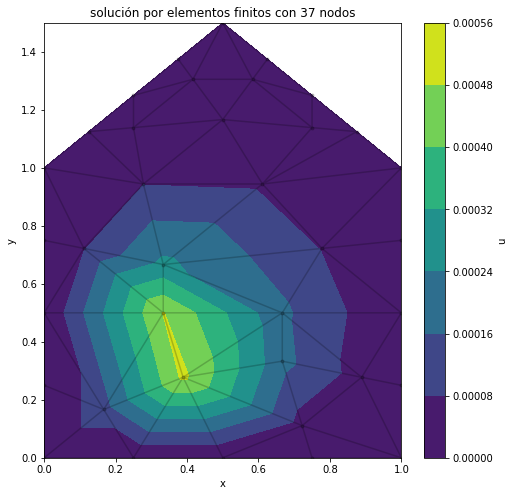

In [12]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0

def f(xs):
    x, y = xs
    return h(x)*h(y)

vs = vertices3
ivsb = ivertices_boundary3
ts = triangles3
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

Text(0.5, 1.0, 'solución por elementos finitos con 325 nodos')

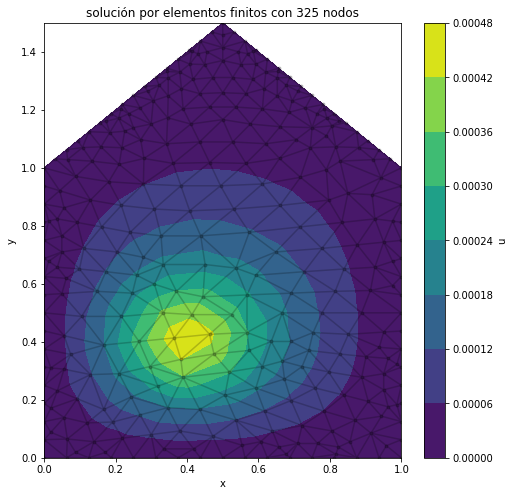

In [13]:
vs = vertices5
ivsb = ivertices_boundary5
ts = triangles5
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

In [14]:
#Máximo de la función u
max(cs)

0.0004550890894078764

En un mallado regular...

Text(0.5, 1.0, 'solución por elementos finitos con 441 nodos')

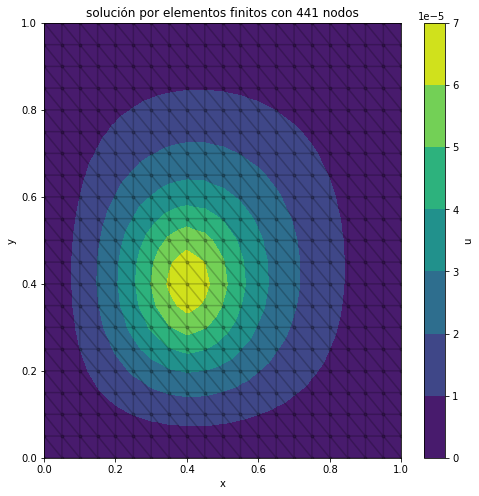

In [15]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0
# Probamos distintos valores
def f(xs):
    x, y = xs
    return h(x)**2*h(y)

vertices, ivertices_boundary, triangles = square_mesh(20, L= 1)
vs = vertices
ivsb = ivertices_boundary
ts = triangles
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

Ahora con la regla de orden 2:
La regla siguiente es de orden 2 (es decir, integra correctamente polinomios de hasta orden 2):
$$
\int_T f(x,y)dx\:dy\approx \frac{|T|}{3} \left(f(m_1)+f(m_2)+f(m_3)
\right)
$$
donde $m_1,m_2,m_3$ son los puntos medios de los lados.

Al aplicar la regla de cuadratura de orden 2 a $\int_T f(x,y)\phi_i(x,y)\:dx$ tenemos:
- $\int_T f(x,y)\phi_1(x,y)\:dx \approx \frac{|T|}{3} (f(mid_{12})\phi_1(mid_{12})+f(mid_{23})\phi_1(mid_{23})+f(mid_{31})\phi_1(mid_{31}))=\frac{|T|}{6}(f(mid_{12})+f(mid_{31}))$
- $\int_T f(x,y)\phi_2(x,y)\:dx \approx \frac{|T|}{3} (f(mid_{12})\phi_2(mid_{12})+f(mid_{23})\phi_2(mid_{23})+f(mid_{31})\phi_2(mid_{31}))=\frac{|T|}{6}(f(mid_{23})+f(mid_{12}))$
- $\int_T f(x,y)\phi_3(x,y)\:dx \approx \frac{|T|}{3} (f(mid_{12})\phi_3(mid_{12})+f(mid_{23})\phi_3(mid_{23})+f(mid_{31})\phi_3(mid_{31}))=\frac{|T|}{6}(f(mid_{31})+f(mid_{23}))$

In [16]:
def solve_FEM(vs, ivsb, ts, f):
    nvs, _ = vs.shape
    nvsb = len(ivsb)
    ivs = np.arange(nvs)

    A = np.zeros((nvs,nvs))
    # Vector b
    b = np.zeros(nvs)
    for triangle in ts:
        P = np.ones((3,3))
        P[:,:2] =vs[triangle,:]
        area = la.det(P)/2
        G = la.inv(P)[:2,:]
        #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
        A[np.ix_(triangle, triangle)] += G.transpose()@G*area

        iv1,iv2,iv3 = triangle
        v1,v2,v3 = vs[iv1],vs[iv2],vs[iv3]
        mid12, mid23, mid31 = (v1+v2)/2, (v2+v3)/2, (v3+v1)/2
        #Integramos f*phi_i
        b[iv1] += (area/6)*(f(mid12) + f(mid31))
        b[iv2] += (area/6)*(f(mid12) + f(mid23))
        b[iv3] += (area/6)*(f(mid31) + f(mid23))

    #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
    A[np.ix_(ivsb, ivs)] = 0
    A[np.ix_(ivs, ivsb)] = 0
    A[np.ix_(ivsb, ivsb)] = np.eye(nvsb)
    return la.solve(A, b)

Text(0.5, 1.0, 'solución por elementos finitos con 325 nodos')

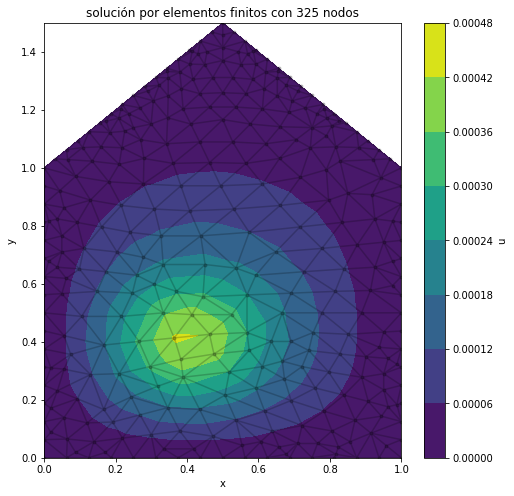

In [17]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0

def f(xs):
    x, y = xs
    return h(x)*h(y)

vs = vertices5
ivsb = ivertices_boundary5
ts = triangles5
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

Text(0.5, 1.0, 'solución por elementos finitos con 441 nodos')

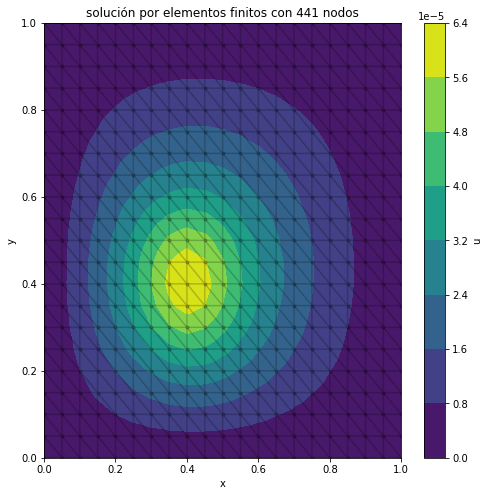

In [18]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0
# Probamos distintos valores
def f(xs):
    x, y = xs
    return h(x)**2*h(y)

vertices, ivertices_boundary, triangles = square_mesh(20, L= 1)
vs = vertices
ivsb = ivertices_boundary
ts = triangles
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

In [19]:
# el valor máximo de u y el punto donde se alcanza

zmax, imax = max(zip(cs, range(len(cs))))
vertices[imax], zmax

(array([0.4, 0.4]), 6.302952388386237e-05)